# Load Packages

- We use `torch`package.
- We use `pytorch_lightning` packages to simplify fitting and evaluate models.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS

### Torch-Specific Imports
There are a number of imports for `torch`. (These are not
included with `ISLP`, so must be installed separately.)
First we import the main library
and essential tools used to specify sequentially-structured networks.

- Main library and essential tools to specify sequentially-structured networks

In [2]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

- Tools from `torchmetrics` to compute metrics to evaluate performance.
- Tools from `torchinfo` to summarize info of the layers of a model.
    - `read_image()` load test images

In [3]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
import torchinfo

- `pytorch_lightning` package simplifies the specification and fitting and evaluate models by reducing amount of boilerplate code needed.
- `pytorch_lightning` is higher-level interface than `torch`.
- `pytorch_lightning` is a high-level module for fitting `torch` models

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

- `seed_everything()` set seed.
- `use_deterministic_algorithms` fix algorithms.

In [5]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


- We use datasets from `torchvision`.
- We use transforms from `torchvision` for preprocessing.
- We use a pretrained network for image classification

In [6]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

- `SimpleDataModule` and `SimpleModule` from `ISLP.torch` are simple versions of objects used in `pytorch_lightning`.
- `ErrorTracker` collects targets and predictions over each mini-batch during validation or testing, enabling metric computation over the entire validation or test data set.

In [7]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

- We use helper functions from `ISLP.torch.imdb` to load data, lookup that maps integers to keys in data.
- We use a modified copy of the preprocessed `imdb` data from `keras`. It saves time for preprocessing.
    - `keras` is a separate package for fitting deep learning models.

In [8]:
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)


- We use `glob()` from `glob` package to find all files matching wildcard characters.
- We use `json` module to load JSON file for looking up classes to identify labels of the pictures in `ResNet50`.

In [9]:
from glob import glob
import json

# Convolutional Neural Networks
- Source: Canadian Institute for Advanced Research (CIFAR).
- Size: 60,000 images in total.
    - Training: 50,000 images.
    - Test: 10,000 images.
- Image Details:
    - Resolution: 32x32 pixels (1024 pixels per image).
    - Channels: 3 (Red, Green, Blue).
    - Pixel Values: Integer values from 0 to 255.
- Class Structure:
    - 100 classes, each containing 600 images.
    - These 100 classes are grouped into 20 superclasses, each containing 5 classes.

In [10]:
cifar_train = CIFAR100(root="data", train=True, download=True, transform=ToTensor())
cifar_test = CIFAR100(root="data", train=False, download=True, transform=ToTensor())
# cifar_train, cifar_test = [CIFAR100(root="data", train=train, download=True) for train in [True, False]]

Files already downloaded and verified
Files already downloaded and verified


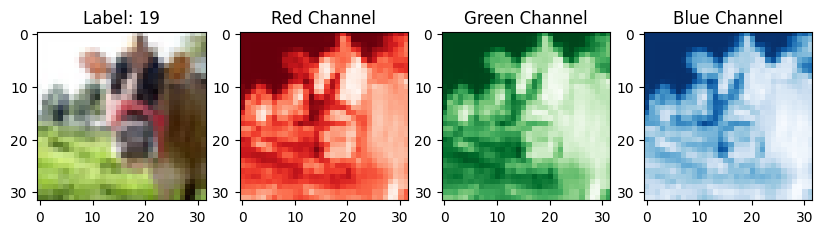

In [11]:
# Get one image and its label from the training set
image, label = cifar_train[0]
# Convert the image tensor to a numpy array and transpose it to (H, W, C) format
image = image.numpy().transpose((1, 2, 0))
# Display the image
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(image); plt.title(f'Label: {label}')
plt.subplot(1, 4, 2)
plt.imshow(image[:,:,0], cmap='Reds'); plt.title('Red Channel')
plt.subplot(1, 4, 3)
plt.imshow(image[:,:,1], cmap='Greens'); plt.title('Green Channel')
plt.subplot(1, 4, 4)
plt.imshow(image[:,:,2], cmap='Blues'); plt.title('Blue Channel');

In [12]:
print(cifar_train[0][0].shape)
cifar_train[0]

torch.Size([3, 32, 32])


(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.8314, 0.7137],
          [1.0000, 0.9961, 0.9961,  ..., 0.6667, 0.6314, 0.5725],
          [1.0000, 0.9961, 1.0000,  ..., 0.7412, 0.6510, 0.4745],
          ...,
          [0.5804, 0.5569, 0.5490,  ..., 0.1176, 0.2549, 0.2980],
          [0.4784, 0.4706, 0.4941,  ..., 0.0863, 0.3804, 0.5529],
          [0.3412, 0.3451, 0.3961,  ..., 0.1333, 0.4118, 0.5412]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.8784, 0.7608],
          [1.0000, 0.9961, 0.9961,  ..., 0.6902, 0.6588, 0.6039],
          [1.0000, 0.9961, 1.0000,  ..., 0.7804, 0.6980, 0.5216],
          ...,
          [0.7255, 0.7137, 0.7020,  ..., 0.0667, 0.2431, 0.3020],
          [0.6157, 0.6078, 0.6275,  ..., 0.0627, 0.4392, 0.6314],
          [0.4784, 0.4784, 0.5255,  ..., 0.1412, 0.5216, 0.6784]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.7569, 0.8000, 0.6549],
          [1.0000, 0.9961, 0.9961,  ..., 0.5882, 0.5098, 0.4431],
          [1.0000, 0.9961, 1.0000,  ...,

In [13]:
print(f"Image shape: {image.shape}")
image

Image shape: (32, 32, 3)


array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.7647059 , 0.8039216 , 0.75686276],
        [0.83137256, 0.8784314 , 0.8       ],
        [0.7137255 , 0.7607843 , 0.654902  ]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.6666667 , 0.6901961 , 0.5882353 ],
        [0.6313726 , 0.65882355, 0.50980395],
        [0.57254905, 0.6039216 , 0.44313726]],

       [[1.        , 1.        , 1.        ],
        [0.99607843, 0.99607843, 0.99607843],
        [1.        , 1.        , 1.        ],
        ...,
        [0.7411765 , 0.78039217, 0.6627451 ],
        [0.6509804 , 0.69803923, 0.50980395],
        [0.4745098 , 0.52156866, 0.34117648]],

       ...,

       [[0.5803922 , 0.7254902 , 0.30980393],
        [0.5568628 , 0.7137255 , 0.22352941],
        [0.54901963, 0

- Second approach to load and transform data.
```python
cifar_train = CIFAR100(root="data", train=True, download=True)
cifar_test = CIFAR100(root="data", train=False, download=True)
```
- Load data first and the transform manually.
```python
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in cifar_test.data])
# Create TensorDataset
cifar_train = TensorDataset(cifar_train_X, torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X, torch.tensor(cifar_test.targets))
```

- `ToTensor()` converts a PIL image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
- We create a data module (_dm) from the training and test datasets, reserving 20% of the training images for validation.

In [14]:
max_num_workers = rec_num_workers()
cifar_dm = SimpleDataModule(cifar_train, cifar_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=128)

- We look at the data that will get fed into our network. We loop through the first two chunks of the training dataset:
    - We iterate the first two batches of the training set and display its shape.
    - Each batch size is 128 images.
    - Each image has dimensions 3 x 32 x 32: 3 channels (RGB), 32 rows, and 32 columns.

In [15]:
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


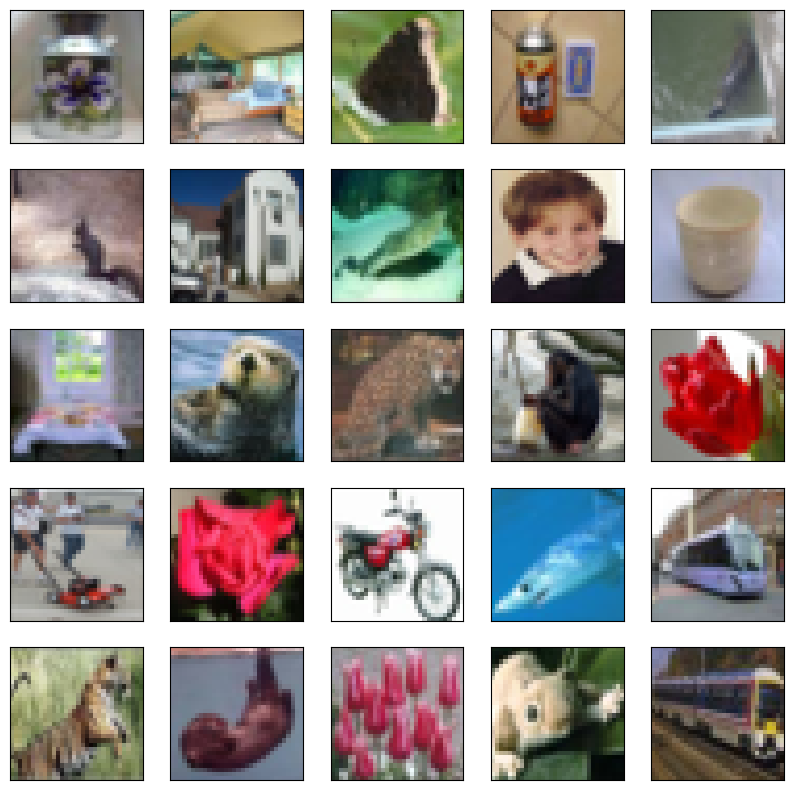

In [16]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(5)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                      [1,2,0]),
                                      interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

- `imshow()` recognizes the shape of the its argument that it is a 3-dimensional tensor. The last dimension is the number of channels.
- We define class `BuildingBlock` that inherits from `nn.Module`.
    - The constructor method initializes the instance with the number of input channels, output channels.
    - Convolutional Layer: `self.conv = ...` defines a 2D convolutional layer with a 3x3 kernel and 'same' padding, meaning the output size will be the same as the input size.
    - Pooling Layer: `self.pool = ...` defines a max-pooling layer with a 2x2 kernel, which reduces the spatial dimensions of the input by a factor of 2.
    - Forward method: the input `x` is passed through the convolutional layer (`self.conv(x)`), followed by a ReLU activation function(`self.activation`), and then through the pooling layer (`self.pool`).

In [17]:
class BuildingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

- We define class `CIFARModel` that inherits from `nn.Module`.
    - The constructor method initializes the instance inheriting from `nn.Module`.
        - We set the size of input and output for each convolutional layer.
        - We create a sequential container of `BuildingBlock` modules, each defined by the sizes in the list.
            - Each `BuildingBlock` module has a convolutional layer, a ReLU activation function, and a max-pooling layer.
        - We define a fully connected layer:
            - `nn.Dropout(0.5)` applies dropout with a probability of 0.5 to prevent overfitting.
            - `nn.Linear(2*2*256, 512)` defines a fully connected layer with 512 output features.
                - The final convolutional layer has 256 channels, and the spatial dimensions are 2x2.
            - `nn.ReLU()` applies a ReLU activation function.
            - `nn.Linear(512, 100)` defines a fully connected layer that maps 512 units to 100 output classes (for CIFAR-100).
        - The forward method passes the input `x` through the convolutional layers (`self.conv(x)`), then flattens the output (`torch.flatten(val, start_dim=1)`) which is 1D tensor, starting from the first dimension. The output is passed through the fully connected layer (`self.output(val)`).
    

In [18]:
class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])

        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

- The first image (3x32x32) of the training set is:
    ```python
    (tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7647, 0.8314, 0.7137],
            [1.0000, 0.9961, 0.9961,  ..., 0.6667, 0.6314, 0.5725],
            [1.0000, 0.9961, 1.0000,  ..., 0.7412, 0.6510, 0.4745],
            ...,
            [0.5804, 0.5569, 0.5490,  ..., 0.1176, 0.2549, 0.2980],
            [0.4784, 0.4706, 0.4941,  ..., 0.0863, 0.3804, 0.5529],
            [0.3412, 0.3451, 0.3961,  ..., 0.1333, 0.4118, 0.5412]],
    
            [[1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.8784, 0.7608],
            [1.0000, 0.9961, 0.9961,  ..., 0.6902, 0.6588, 0.6039],
            [1.0000, 0.9961, 1.0000,  ..., 0.7804, 0.6980, 0.5216],
            ...,
            [0.7255, 0.7137, 0.7020,  ..., 0.0667, 0.2431, 0.3020],
            [0.6157, 0.6078, 0.6275,  ..., 0.0627, 0.4392, 0.6314],
            [0.4784, 0.4784, 0.5255,  ..., 0.1412, 0.5216, 0.6784]],
    
            [[1.0000, 1.0000, 1.0000,  ..., 0.7569, 0.8000, 0.6549],
            [1.0000, 0.9961, 0.9961,  ..., 0.5882, 0.5098, 0.4431],
            [1.0000, 0.9961, 1.0000,  ..., 0.6627, 0.5098, 0.3412],
            ...,
            [0.3098, 0.2235, 0.2353,  ..., 0.0039, 0.0588, 0.0784],
            [0.2588, 0.2275, 0.2784,  ..., 0.0118, 0.2196, 0.3412],
            [0.1608, 0.1529, 0.2196,  ..., 0.0392, 0.2314, 0.3098]]]),
    19)
    ```

1. The `CIFARModel` instance is initialized, creating a sequence of `BuildingBlock` modules and a fully connected layer.
2. The first `BuildingBlock` takes the input image (3x32x32) and apply 32 filters (kernels), each is 3x3. Example for the first element (top-left) of the first image:
    - Red Channel:
        ```python
        [[1.0000, 1.0000, 1.0000],
        [1.0000, 0.9961, 0.9961],
        [1.0000, 0.9961, 1.0000]]
        ```
    - Green Channel:
        ```python
        [[1.0000, 1.0000, 1.0000],
        [1.0000, 0.9961, 0.9961],
        [1.0000, 0.9961, 1.0000]]
        ```
    - Blue Channel:
        ```python
        [[1.0000, 1.0000, 1.0000],
        [1.0000, 0.9961, 0.9961],
        [1.0000, 0.9961, 1.0000]]
        ```
    - Apply the first filter (not true number, just for example):
        ```python
        [[1, 0, -1],
        [1, 0, -1],
        [1, 0, -1]]
        ```
    - Each element of kernel multiply with the corresponding element of each channel:
        ```python
        Red                             Green                           Blue
        [[ 1.0000,  0.0000, -1.0000],   [[ 1.0000,  0.0000, -1.0000],   [[ 1.0000,  0.0000, -1.0000],
        [ 1.0000,  0.0000, -0.9961],    [ 1.0000,  0.0000, -0.9961],    [ 1.0000,  0.0000, -0.9961],
        [ 1.0000,  0.0000, -1.0000]]    [ 1.0000,  0.0000, -1.0000]]    [ 1.0000,  0.0000, -1.0000]]
        ```
    - Sum the results across the channels:
        ```python
        (1.0000 + 1.0000 + 1.0000) + (0.0000 + 0.0000 + 0.0000) + (-1.0000 - 1.0000 - 1.0000) +
        (1.0000 + 1.0000 + 1.0000) + (0.0000 + 0.0000 + 0.0000) + (-0.9961 - 0.9961 - 0.9961) +
        (1.0000 + 1.0000 + 1.0000) + (0.0000 + 0.0000 + 0.0000) + (-1.0000 - 1.0000 - 1.0000) = 0.0117
        ```
    - The value at the top-left corner of the output feature map for this filter is 0.0117.
    - `padding = "same"` ensures that in the end of right and bottom sides, filter can be applied, resulting in the same 32 x 32 of the input.
    - Each filter is applied to the entire image, resulting in a 32 x 32 feature map.
    - The output of the first convolutional layer is 32 x 32 x 32 because of 32 filters.

3. The output of the first convolutional layer is passed through the ReLU activation function.
4. The output of the ReLU activation function is passed through the max-pooling layer, which reduces the spatial dimensions by a factor of 2. Example for max-pooling:
    ```python
    [[1, 2, 3, 4],      
    [5, 6, 7, 8]]  ->   [6, 8]
    ```
5. Sequential `BuildingBlock`: 
    - The output of the first `BuildingBlock` is 32x16x16. It passes through the second `BuildingBlock`.
    - The output of the second `BuildingBlock` is 64x8x8. -//-
    - The output of the third `BuildingBlock` is 128x4x4. -//-
    - The output of the fourth `BuildingBlock` is 256x2x2.
6. The output of the fourth `BuildingBlock` is flattened to a 1D tensor of size 1024 (256x2x2). Then it passes through the fully connected layer.
    - First, apply dropout with a probability of 0.5 to prevent overfitting.
    - Then, it passes through a layer with 512 output features.
    - Apply ReLU activation function.
    - Finally, it passes through a layer with 100 output features.


- We check with examples of `X_` containing only two images.

In [19]:
cifar_model = CIFARModel()
torchinfo.summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

- The total number of trainable parameters is 964,516.
- We initialize the RMSprop optimizer with a learning rate of 0.001. We set the learning rate to be smaller  because experiments show that it performs better than the default learning rate of 0.01.
    - `RMSprop` is a gradient-based optimization algorithm that adjusts the learning rate for each parameter.
    - `cifar_model.parameters()` passes the parameters of the ``cifar_model`` to the optimizer.
- We initialize the ``SimpleModule`` with the model, optimizer, loss function, and metric.
    - ``SimpleModule.classification`` is a method that sets up the model for classification.
    - ``cifar_model`` is the network model to be used for classification.
- ``CSVLogger`` logs the training and validation metrics to a CSV file.

In [20]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model,
                                    num_classes=100,
                                    optimizer=cifar_optimizer)
cifar_logger = CSVLogger('logs', name='CIFAR100')

In [21]:
cifar_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=cifar_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module,
                  datamodule=cifar_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


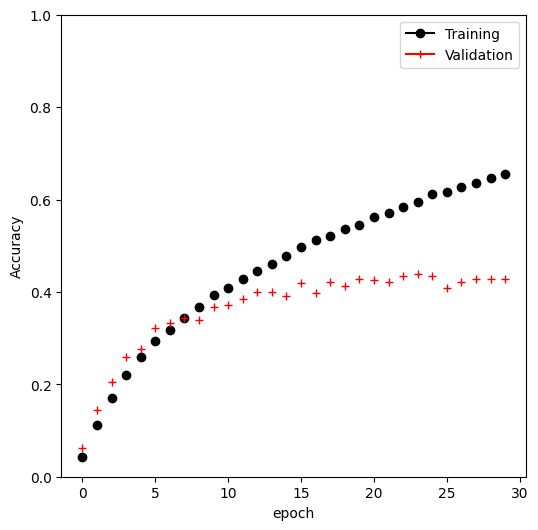

In [22]:
cifar_results = pd.read_csv(cifar_logger.experiment.metrics_file_path)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cifar_results
cifar_results.plot(x='epoch', y='train_accuracy_epoch', ax=ax, label='Training', marker='o', color='k')
cifar_results.plot(x='epoch', y='valid_accuracy', ax=ax, label='Validation', marker='+', color='r')
ax.set_ylim([0, 1]); ax.set_ylabel('Accuracy'); ax.set_xticks(np.linspace(0, 30, 7));


- We evaluate our model on our test data.

In [23]:
cifar_trainer.test(cifar_module, datamodule=cifar_dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4323999881744385     │
│         test_loss         │    2.3359861373901367     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.3359861373901367, 'test_accuracy': 0.4323999881744385}]

- The accuracy of the model on the test data is 43%. This is not a great result, but it is better than random guessing, which would be 1% accuracy for 100 classes.
- On the web, the results are around 75% accuracy. It takes a lot of architecture carpentry, fiddling with regularization, and time to achieve such results.

# Hardware Acceleration
- Hardware manufacturers offer specialized libraries to accelerate gradient descent.
- For example, Mac OS devices with the M1 chip can use the Metal framework to speed up ``torch`` computations. We demonstrate how to leverage this acceleration. Metrics must be informed of the data location during evaluation, which is done using the ``to()`` method.
- The code below results in a two- to three-fold acceleration per epoch.
    - The code is wrapped in ``try:`` and ``except:`` clauses: if the acceleration works, it's applied; if it fails, nothing happens.
    - The requirement for ``mps`` accerlation is that the device is a Mac with an M1 chip.
- For NVIDIA GPUs, the ``torch.cuda`` library is used to accelerate computations.
    - Replace 'mps' with 'cuda' to use NVIDIA GPUs.
- Replace 'mps' with 'cpu' to back to the CPU.

In [24]:
# Check if MPS is available
print("MPS is available: ", torch.backends.mps.is_available())
# Check if CUDA is available
print("CUDA is available: ", torch.cuda.is_available())


MPS is available:  False
CUDA is available:  False


In [25]:
try:
    for name, metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
    cifar_trainer_mps = Trainer(accelerator='mps',
                                deterministic=True,
                                enable_progress_bar=False,
                                max_epochs=30)
    cifar_trainer_mps.fit(cifar_module, datamodule=cifar_dm)
    cifar_trainer_mps.test(cifar_module, datamodule=cifar_dm)
except:
    pass

# ImageNet and ResNet50
- ImageNet:
    - Overview: ImageNet contains over 14 million images, organized into 20,000+ categories (synsets) based on WordNet hierarchy.
    - Labels: Each image is manually annotated with one or more labels indicating the objects present.
    - ILSVRC: The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) is an annual competition that involves classifying images into 1,000 categories, object detection, and more.
- ResNet50:
    - Overview: RResNet-50 is a deep convolutional neural network (CNN) with 50 layers, part of the Residual Networks (ResNet) family. It uses residual blocks with shortcut (skip) connections to mitigate the vanishing gradient problem and facilitate training of very deep networks.
    - Residual Blocks: Instead of learning a direct input-output mapping, residual blocks learn the residual (difference) between input and output. Shortcut connections bypass layers, allowing gradients to flow more easily during backpropagation.
    - Layers: The network is composed of a mix of convolutional layers, batch normalization, ReLU activations, and fully connected layers.
    - ResNet-50 is divided into multiple stages, each consisting of several residual blocks. Stages are separated by downsampling layers, typically using stride-2 convolutions, to reduce the spatial dimensions of feature maps.
    - Architecture:
        1. Initial Layers:
            - 7x7 convolutional layer with 64 filters and stride 2
            - Batch normalization and ReLU activation
            - 3x3 max pooling layer with stride 2
        2. Residual Blocks:
            - Stage 1: 3 residual blocks, each with 3 layers (1x1, 3x3, 1x1 convolutions)
            - Stage 2: 4 residual blocks, each with 3 layers
            - Stage 3: 6 residual blocks, each with 3 layers
            - Stage 4: 3 residual blocks, each with 3 layers
        3. Final Layers:
            - Global average pooling layer
            - Fully connected layer with 1000 units (for ImageNet classification)
            - Softmax activation
- We read in JPEG images from the `book_images` directory.
- We convert them into arrays format expected by `torch` to match the specifications in `resnet50`.
    - The conversion involves a resize, a crop, a predefined standardization for each of the three channels.

In [26]:
# Define transformations
resize = Resize((232, 232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Get list of image files
imgfiles = sorted([f for f in glob('book_images/*')])

# Debugging: Print the list of image files
print("Image files found:", imgfiles)

# Check if imgfiles is empty
if not imgfiles:
    raise RuntimeError("No image files found in the specified directory.")

Image files found: ['book_images\\A_Bird.jpg', 'book_images\\Cape_Weaver.jpg', 'book_images\\Hawk_Fountain.jpg', 'book_images\\Hawk_cropped.jpg', 'book_images\\Lhasa_Apso.jpg', 'book_images\\Sleeping_Cat.jpg']


In [27]:
resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([6, 3, 224, 224])

We now set up the trained network with the weights we read in code block~6. The model has 50 layers, with a fair bit of complexity.

In [28]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
torchinfo.summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

We set the mode to `eval()` to ensure that the model is ready to predict on new data.

In [29]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Inspecting the output above, we see that when setting up the
`resnet_model`, the authors defined a `Bottleneck`, much like our
`BuildingBlock` module.

We now feed our six images through the fitted network.

In [30]:
img_preds = resnet_model(imgs)

Let’s look at the predicted probabilities for each of the top 3 choices. First we compute
the probabilities by applying the softmax to the logits in `img_preds`. Note that
we have had to call the `detach()` method on the tensor `img_preds` in order to convert
it to our a more familiar `ndarray`.

In [31]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]


In order to see the class labels, we must download the index file associated with `imagenet`. {This is avalable from the book website and  [s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json](https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json).}

In [32]:
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in 
                           labs.items()],
                           columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()


We’ll now construct a data frame for each image file
with the labels with the three highest probabilities as
estimated by the model above.

In [33]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))


Image: book_images\A_Bird.jpg
         label      prob
0    goldfinch  0.475013
1    brambling  0.002423
2  house_finch  0.002217
Image: book_images\Cape_Weaver.jpg
      label      prob
0   jacamar  0.297500
1     macaw  0.068107
2  lorikeet  0.051104
Image: book_images\Hawk_Fountain.jpg
            label      prob
0            kite  0.184716
1           robin  0.084018
2  great_grey_owl  0.061267
Image: book_images\Hawk_cropped.jpg
            label      prob
0            kite  0.453834
1  great_grey_owl  0.015914
2             jay  0.012210
Image: book_images\Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097195
2  Tibetan_terrier  0.032820
Image: book_images\Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578


We see that the model
is quite confident about `Flamingo.jpg`, but a little less so for the
other images.

We end this section with our usual cleanup.

In [34]:
del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)